In [1]:
!pip install -q transformers datasets accelerate peft bitsandbytes trl sentencepiece torch

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [17]:
# Add at the beginning of your notebook
import os
import torch

# Disable JIT compilation to avoid libnvrtc errors
os.environ['PYTORCH_JIT'] = '0'
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'

# Force PyTorch to use only pre-compiled operations
torch.jit.enable = lambda: None
torch._C._jit_set_profiling_executor(False)
torch._C._jit_set_profiling_mode(False)
torch._C._jit_override_can_fuse_on_cpu(False)
torch._C._jit_override_can_fuse_on_gpu(False)

In [ ]:
# Run this in a terminal cell
!apt-get update
!apt-get install -y nvidia-cuda-toolkit

In [2]:
import os
import torch
import pandas as pd
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    BitsAndBytesConfig,
    DataCollatorForLanguageModeling, # Correct collator for Causal LM
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from trl import SFTTrainer # Simplified trainer for supervised fine-tuning

In [3]:
from huggingface_hub import login
login(token="YOUR TOKEN")

In [4]:
# --- Configuration ---
model_id = "mistralai/Mistral-7B-Instruct-v0.3"
dataset_name = "Hello-SimpleAI/HC3"
dataset_subset = "reddit_eli5"
new_model_name = "mistral-7b-humanizer-v1" # Name for saving adapters

# --- 1. Load Dataset ---
print("Loading dataset...")
dataset = load_dataset(dataset_name, dataset_subset, split="train")
# Optional: Sample a smaller subset for faster testing/iteration
# dataset = dataset.shuffle(seed=42).select(range(500))
# print(f"Using a subset of {len(dataset)} examples")


print(f"Dataset loaded with {len(dataset)} examples")
print(f"Dataset structure: {dataset}")

Loading dataset...
Dataset loaded with 17112 examples
Dataset structure: Dataset({
    features: ['id', 'question', 'human_answers', 'chatgpt_answers'],
    num_rows: 17112
})


In [5]:
# Explore dataset structure
print(f"Columns: {dataset.column_names}")

# Check a few examples
for i in range(3):
    print(f"\nExample {i}:")
    print(f"Question: {dataset[i]['question']}\n")
    print(f"Human answers (first one): {dataset[i]['human_answers'][0][:100]}...\n")
    print(f"ChatGPT answer: {dataset[i]['chatgpt_answers'][0][:100]}...\n")


Columns: ['id', 'question', 'human_answers', 'chatgpt_answers']

Example 0:
Question: Why is every book I hear about a " NY Times # 1 Best Seller " ? ELI5 : Why is every book I hear about a " NY Times # 1 Best Seller " ? Should n't there only be one " # 1 " best seller ? Please explain like I'm five.

Human answers (first one): Basically there are many categories of " Best Seller " . Replace " Best Seller " by something like "...

ChatGPT answer: There are many different best seller lists that are published by various organizations, and the New ...


Example 1:
Question: If salt is so bad for cars , why do we use it on the roads ? As the title states , why do we use it ? is there no other option or what ? Please explain like I'm five.

Human answers (first one): salt is good for not dying in car crashes and car crashes are worse for cars then salt . Some places...

ChatGPT answer: Salt is used on roads to help melt ice and snow and improve traction during the winter months. When ...




Dataset loaded with 17112 examples

Statistics for longest human answer per example:
Average length: 240.20 words
Median length: 170.00 words
Maximum length: 7904 words
Minimum length: 11 words

Overall statistics:
Average human answer length: 133.27 words
Average AI answer length: 174.88 words
Ratio of AI to human length: 1.31x


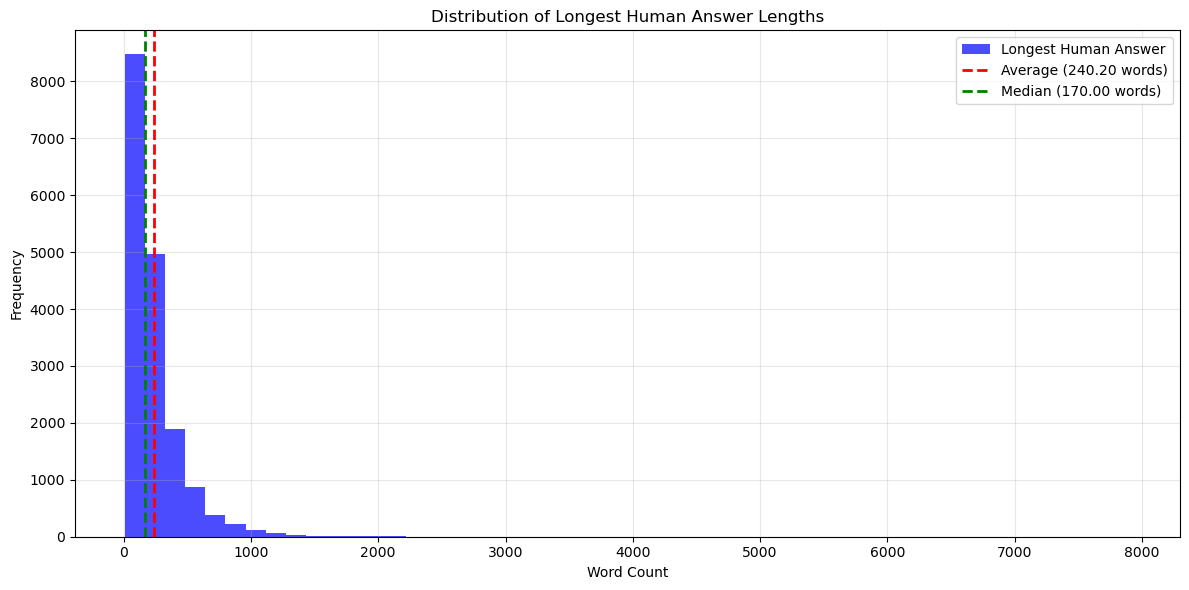

In [6]:
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt

# Load the HC3 dataset, specifically the reddit_eli5 subset
dataset = load_dataset("Hello-SimpleAI/HC3", "reddit_eli5")
print(f"Dataset loaded with {len(dataset['train'])} examples")

# Function to calculate word count
def count_words(text):
    return len(text.split())

# Calculate lengths for all human answers and AI answers
human_lengths = []
ai_lengths = []
longest_human_per_example = []

for example in dataset['train']:
    # Get lengths of all human answers for this example
    human_answer_lengths = [count_words(answer) for answer in example['human_answers']]
    
    # Store the length of the longest human answer for this example
    if human_answer_lengths:
        longest_human_per_example.append(max(human_answer_lengths))
    
    # Add all lengths to the overall list
    human_lengths.extend(human_answer_lengths)
    
    # Get lengths of all AI answers for this example
    ai_answer_lengths = [count_words(answer) for answer in example['chatgpt_answers']]
    ai_lengths.extend(ai_answer_lengths)

# Calculate statistics for the longest human answer per example
avg_longest_human = np.mean(longest_human_per_example)
median_longest_human = np.median(longest_human_per_example)
max_longest_human = np.max(longest_human_per_example)
min_longest_human = np.min(longest_human_per_example)

print(f"\nStatistics for longest human answer per example:")
print(f"Average length: {avg_longest_human:.2f} words")
print(f"Median length: {median_longest_human:.2f} words")
print(f"Maximum length: {max_longest_human} words")
print(f"Minimum length: {min_longest_human} words")

# Calculate overall statistics
avg_human = np.mean(human_lengths)
avg_ai = np.mean(ai_lengths)

print(f"\nOverall statistics:")
print(f"Average human answer length: {avg_human:.2f} words")
print(f"Average AI answer length: {avg_ai:.2f} words")
print(f"Ratio of AI to human length: {avg_ai/avg_human:.2f}x")

# Create a histogram to visualize the distribution
plt.figure(figsize=(12, 6))
plt.hist(longest_human_per_example, bins=50, alpha=0.7, color='blue', label='Longest Human Answer')
plt.axvline(avg_longest_human, color='red', linestyle='dashed', linewidth=2, label=f'Average ({avg_longest_human:.2f} words)')
plt.axvline(median_longest_human, color='green', linestyle='dashed', linewidth=2, label=f'Median ({median_longest_human:.2f} words)')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Longest Human Answer Lengths')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('human_answer_length_distribution.png')
plt.show()


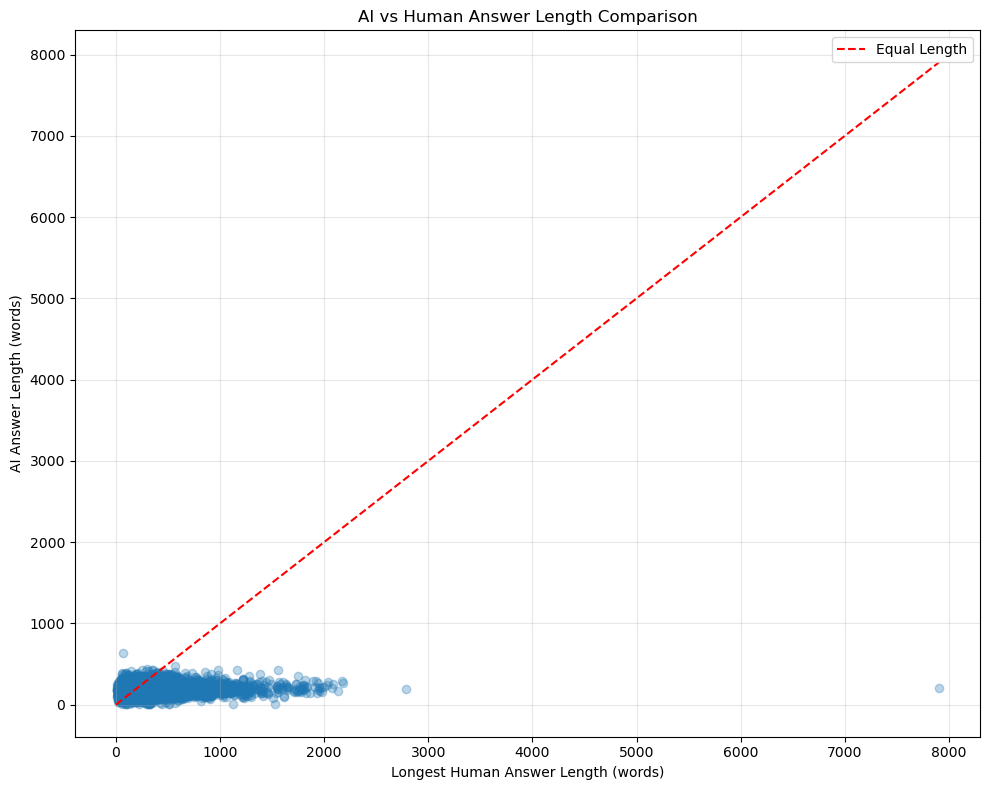

In [7]:
ai_for_scatter = []
human_for_scatter = []

for example in dataset['train']:
    if example['human_answers'] and example['chatgpt_answers']:
        longest_human = max([count_words(answer) for answer in example['human_answers']])
        ai_length = count_words(example['chatgpt_answers'][0])  # Using first AI answer
        
        human_for_scatter.append(longest_human)
        ai_for_scatter.append(ai_length)

plt.figure(figsize=(10, 8))
plt.scatter(human_for_scatter, ai_for_scatter, alpha=0.3)
plt.plot([0, max(human_for_scatter)], [0, max(human_for_scatter)], 'r--', label='Equal Length')
plt.xlabel('Longest Human Answer Length (words)')
plt.ylabel('AI Answer Length (words)')
plt.title('AI vs Human Answer Length Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('ai_vs_human_length.png')
plt.show()

Original dataset loaded with 17112 examples
Calculated longest human answer lengths for 17112 examples.

--- Outlier Detection based on Longest Human Answer Length ---
Q1 (25th percentile): 101.00 words
Q3 (75th percentile): 298.00 words
IQR: 197.00 words
Calculated Upper Bound (Q3 + 1.5*IQR): 593.50
User-defined Minimum Length: 75 words
Effective Lower Bound: 75 words
Effective Upper Bound: 593.50 words

--- Filtering Results ---
Original dataset size: 17112
Filtered dataset size: 13707
Number of examples removed: 3405

Statistics for FILTERED dataset:
                   Filtered
Average Longest      219.31
Median Longest       183.00
Max Longest          593.00
Min Longest           75.00
Avg Overall Human    126.48
Avg Overall AI       175.72


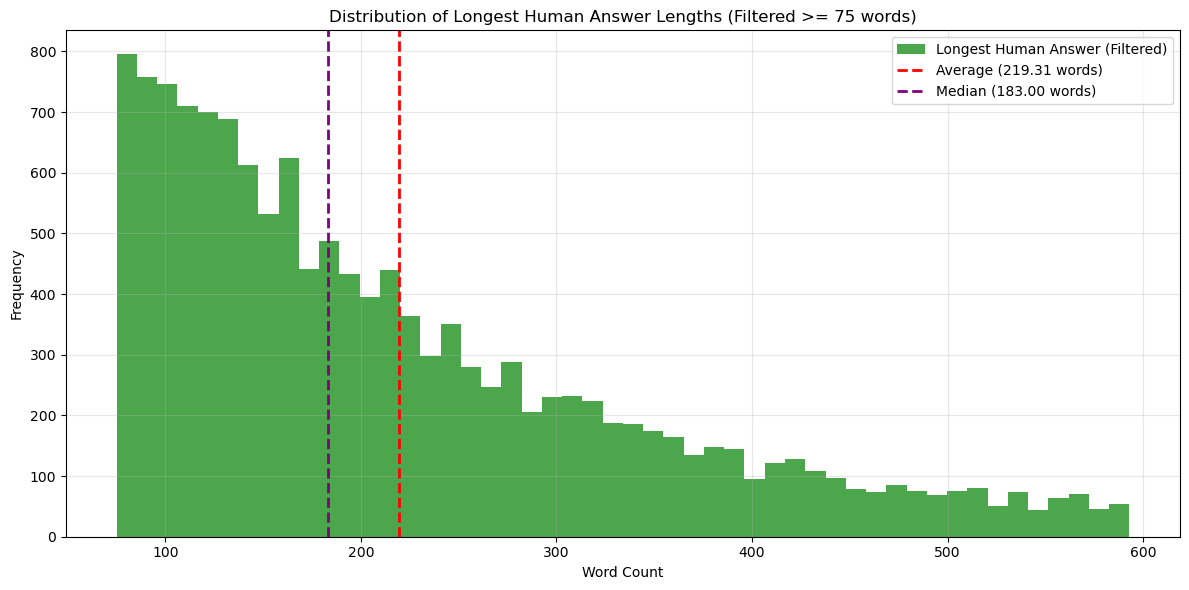

In [8]:
import numpy as np
from datasets import load_dataset, Dataset
import matplotlib.pyplot as plt
import pandas as pd # For easier display of stats

# Load the HC3 dataset, specifically the reddit_eli5 subset
dataset = load_dataset("Hello-SimpleAI/HC3", "reddit_eli5", split="train") # Load as Dataset object
print(f"Original dataset loaded with {len(dataset)} examples")

# --- Step 1: Calculate the length of the longest human answer for each example ---
def get_longest_human_length(example):
    """Calculates the word count of the longest human answer in an example."""
    if not example['human_answers']:
        return 0 # Handle cases with no human answers
    human_lengths = [len(answer.split()) for answer in example['human_answers']]
    return max(human_lengths) if human_lengths else 0

# Apply the function to get a list of max lengths
longest_human_lengths = dataset.map(lambda x: {'longest_len': get_longest_human_length(x)})['longest_len']
print(f"Calculated longest human answer lengths for {len(longest_human_lengths)} examples.")

# --- Step 2: Calculate IQR bounds for the longest lengths ---
q1 = np.percentile(longest_human_lengths, 25)
q3 = np.percentile(longest_human_lengths, 75)
iqr = q3 - q1

# Define outlier bounds using 1.5 * IQR rule
# We only care about the upper bound for IQR outlier removal now
upper_bound = q3 + 1.5 * iqr

# Define the explicit minimum length required by the user
user_min_length = 75

# The effective lower bound is now simply the user's requirement
lower_bound = user_min_length

print(f"\n--- Outlier Detection based on Longest Human Answer Length ---")
print(f"Q1 (25th percentile): {q1:.2f} words")
print(f"Q3 (75th percentile): {q3:.2f} words")
print(f"IQR: {iqr:.2f} words")
print(f"Calculated Upper Bound (Q3 + 1.5*IQR): {upper_bound:.2f}")
print(f"User-defined Minimum Length: {user_min_length} words")
print(f"Effective Lower Bound: {lower_bound} words") # Now set to user_min_length
print(f"Effective Upper Bound: {upper_bound:.2f} words")

# --- Step 3: Filter the dataset ---
# Keep examples where the longest human answer length is within the bounds
# (>= user_min_length AND <= upper_bound)
filtered_dataset = dataset.filter(
    lambda x: lower_bound <= get_longest_human_length(x) <= upper_bound
)

print(f"\n--- Filtering Results ---")
print(f"Original dataset size: {len(dataset)}")
print(f"Filtered dataset size: {len(filtered_dataset)}")
print(f"Number of examples removed: {len(dataset) - len(filtered_dataset)}")

# --- Step 4: Analyze the filtered dataset (Optional but recommended) ---
if len(filtered_dataset) > 0:
    filtered_human_lengths = []
    filtered_ai_lengths = []
    filtered_longest_human_per_example = filtered_dataset.map(
        lambda x: {'longest_len': get_longest_human_length(x)}
    )['longest_len']

    for example in filtered_dataset:
        filtered_human_lengths.extend([len(ans.split()) for ans in example['human_answers']])
        filtered_ai_lengths.extend([len(ans.split()) for ans in example['chatgpt_answers']])

    # Calculate statistics for the filtered longest human answers
    stats_filtered = {
        "Average Longest": np.mean(filtered_longest_human_per_example),
        "Median Longest": np.median(filtered_longest_human_per_example),
        "Max Longest": np.max(filtered_longest_human_per_example),
        "Min Longest": np.min(filtered_longest_human_per_example), # Should now be >= 50
        "Avg Overall Human": np.mean(filtered_human_lengths) if filtered_human_lengths else 0,
        "Avg Overall AI": np.mean(filtered_ai_lengths) if filtered_ai_lengths else 0,
    }

    print("\nStatistics for FILTERED dataset:")
    stats_df = pd.DataFrame([stats_filtered], index=['Filtered']).T
    print(stats_df.to_string(float_format='{:.2f}'.format))


    # --- Step 5: Visualize the filtered distribution ---
    plt.figure(figsize=(12, 6))
    plt.hist(filtered_longest_human_per_example, bins=50, alpha=0.7, color='green', label='Longest Human Answer (Filtered)')
    plt.axvline(stats_filtered["Average Longest"], color='red', linestyle='dashed', linewidth=2, label=f'Average ({stats_filtered["Average Longest"]:.2f} words)')
    plt.axvline(stats_filtered["Median Longest"], color='purple', linestyle='dashed', linewidth=2, label=f'Median ({stats_filtered["Median Longest"]:.2f} words)')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Longest Human Answer Lengths (Filtered >= {user_min_length} words)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('filtered_human_answer_length_distribution_min50.png')
    plt.show()
else:
    print("\nFiltered dataset is empty, cannot calculate statistics or plot.")


# Now you can use 'filtered_dataset' for your training
# Example:
# formatted_filtered_dataset = filtered_dataset.map(format_example) # Assuming format_example exists
# trainer = SFTTrainer(..., train_dataset=formatted_filtered_dataset, ...)



In [9]:
# --- 2. Prepare Dataset in Instruction Format ---
# We need to format the data into a prompt template that Mistral Instruct understands.
# The format is typically: <s>[INST] Instruction [/INST] Response </s>
def format_example_longest_detailed(example):
    """
    Formats the dataset example for Mistral Instruct fine-tuning.
    Uses the LONGEST human answer as the target response and includes
    an enhanced instruction prompt to encourage detailed output.
    """
    try:
        # --- Input Validation ---
        # Ensure required fields exist and are not empty
        question = example.get('question')
        human_answers = example.get('human_answers')
        chatgpt_answers = example.get('chatgpt_answers')

        if not question or not human_answers or not chatgpt_answers or not chatgpt_answers[0]:
            # print("Skipping example due to missing/empty required fields.") # Optional debug print
            return {"text": ""} # Return empty text to filter out later

        ai_response = chatgpt_answers[0] # Use the first AI response

        # --- Find the Longest Human Answer ---
        # Filter out any potentially empty strings from human_answers first
        valid_human_answers = [ans for ans in human_answers if ans and ans.strip()]
        if not valid_human_answers:
            # print(f"Skipping example: No valid human answers found for question ID {example.get('id', 'N/A')}") # Optional debug print
            return {"text": ""} # No valid human answer to use

        # Find the longest answer based on word count
        longest_human_answer = max(valid_human_answers, key=lambda x: len(x.split()))

        # --- Construct the Enhanced Prompt ---
        # This prompt explicitly asks the model to maintain detail while sounding human.
        # You can experiment with different phrasings here.
        prompt_instruction = (
            "Rewrite the following AI response to the question so it sounds more "
            "natural and human-like, while ensuring the key information and "
            "level of detail are preserved."
            # Alternative phrasing ideas:
            # "Humanize the AI response below. Provide a comprehensive explanation "
            # "that sounds like it was written by a person."
            # "Make the following AI response sound more human. Ensure your answer "
            # "is detailed and covers the main points accurately."
        )

        # Construct the final text string for the trainer
        text = (
            f"<s>[INST] {prompt_instruction}\n\n"
            f"Question: \"{question}\"\n\n"
            f"AI Response: \"{ai_response}\" [/INST] "
            f"{longest_human_answer} </s>" # Target is the longest human answer
        )
        return {"text": text}

    except (KeyError, IndexError, TypeError) as e:
        # Catch potential errors during dictionary/list access
        # print(f"Error processing example: {e}. Skipping.") # Optional debug print
        return {"text": ""} # Return empty on error

In [10]:
print("Formatting dataset...")
formatted_dataset = filtered_dataset.map(format_example_longest_detailed)

# Remove original columns if desired (SFTTrainer mainly needs 'text')
# formatted_dataset = formatted_dataset.remove_columns(dataset.column_names)

# Filter out the null ones
formatted_dataset = formatted_dataset.filter(lambda x: len(x['text']) > 0)
print(len(formatted_dataset))
formatted_dataset

Formatting dataset...
13348


Dataset({
    features: ['id', 'question', 'human_answers', 'chatgpt_answers', 'text'],
    num_rows: 13348
})

In [11]:
print(f"{formatted_dataset[0]['text']}")

<s>[INST] Rewrite the following AI response to the question so it sounds more natural and human-like, while ensuring the key information and level of detail are preserved.

Question: "Why is every book I hear about a " NY Times # 1 Best Seller " ? ELI5 : Why is every book I hear about a " NY Times # 1 Best Seller " ? Should n't there only be one " # 1 " best seller ? Please explain like I'm five."

AI Response: "There are many different best seller lists that are published by various organizations, and the New York Times is just one of them. The New York Times best seller list is a weekly list that ranks the best-selling books in the United States based on sales data from a number of different retailers. The list is published in the New York Times newspaper and is widely considered to be one of the most influential best seller lists in the book industry. 
It's important to note that the New York Times best seller list is not the only best seller list out there, and there are many other

In [12]:
# --- 3. Load Tokenizer and Model ---
print(f"Loading base model and tokenizer: {model_id}...")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
tokenizer.padding_side = "right" # Important for Causal LM training

# Configure quantization (QLoRA) to load model in 4-bit
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16, # Use bfloat16 for Ampere GPUs (like RTX 6000)
    bnb_4bit_use_double_quant=False,
)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    torch_dtype=torch.bfloat16,
    device_map="auto", # Automatically distributes model across available GPUs
    trust_remote_code=True,
)
model.config.use_cache = False # Disable cache for training
model.config.pretraining_tp = 1 # Set for TRL compatibility if needed

Loading base model and tokenizer: mistralai/Mistral-7B-Instruct-v0.3...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [13]:
# --- 4. Configure PEFT (LoRA) ---
print("Configuring PEFT (LoRA)...")

# Prepare model for k-bit training (important when using quantization)
model = prepare_model_for_kbit_training(model)

# LoRA configuration
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=32, # Rank of the LoRA matrices
    bias="none",
    task_type="CAUSAL_LM",
    # Target modules can vary, inspect model architecture if needed
    # Common targets for Mistral:
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
)

# Apply LoRA adapter to the model
model = get_peft_model(model, peft_config)

# Print trainable parameters to verify LoRA setup
model.print_trainable_parameters()

Configuring PEFT (LoRA)...
trainable params: 83,886,080 || all params: 7,331,909,632 || trainable%: 1.1441


In [14]:
# --- 5. Configure Training Arguments ---
print("Configuring Training Arguments...")

training_arguments = TrainingArguments(
    output_dir=f"./results/{new_model_name}",
    num_train_epochs=1, # 1-3 epochs is often enough for LoRA
    per_device_train_batch_size=1, # Adjust based on VRAM (start low)
    gradient_accumulation_steps=8, # Increase effective batch size
    optim="adamw_torch", # Memory efficient optimizer
    save_steps=500, # Save checkpoints periodically
    logging_steps=100, # Log training progress frequently
    learning_rate=2e-4, # Common learning rate for LoRA
    weight_decay=0.001,
    fp16=False, # bf16 enabled via BitsAndBytesConfig compute_dtype
    bf16=False, # Use bfloat16 for training
    max_grad_norm=0.3, # Gradient clipping
    max_steps=-1, # Set to -1 to train for num_train_epochs
    warmup_ratio=0.03, # Warmup steps for learning rate
    group_by_length=True, # Group sequences of similar length for efficiency
    lr_scheduler_type="cosine", # Learning rate scheduler
    report_to="tensorboard", # Or "wandb", "none"
    gradient_checkpointing = True
    # evaluation_strategy="steps", # Add if you have a validation set
    # eval_steps=200,             # Add if you have a validation set
)

Configuring Training Arguments...


In [15]:
# --- 6. Initialize Trainer (SFTTrainer) ---
print("Initializing Trainer...")

# Initialize trainer with minimal arguments
trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=formatted_dataset,
    processing_class=tokenizer,
    peft_config=peft_config,
)

# --- 7. Train the Model ---
print("Starting training...")
# Add a try-except block to catch and report errors more clearly
try:
    trainer.train()
    print("Training finished.")
except Exception as e:
    print(f"Training error: {e}")
    import traceback
    traceback.print_exc()


# --- 8. Save the Trained LoRA Adapter ---
print(f"Saving LoRA adapter weights to ./{new_model_name}-final")
trainer.model.save_pretrained(f"./{new_model_name}-final") # Saves only the adapter
tokenizer.save_pretrained(f"./{new_model_name}-final") # Save tokenizer with adapter
print("Adapter saved.")


Initializing Trainer...


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Starting training...


Step,Training Loss
100,1.507200
200,1.351700
300,1.355500
400,1.352800
500,1.341300
600,1.320900
700,1.335100
800,1.339800
900,1.336100
1000,1.331200


Training finished.
Saving LoRA adapter weights to ./mistral-7b-humanizer-v1-final
Adapter saved.


In [16]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel
import warnings
warnings.filterwarnings("ignore")

def test_humanizer_model(question, ai_response, base_model_id, adapter_path, hf_token):
    """
    Test a fine-tuned humanizer model by generating a humanized response
    
    Args:
        question (str): The original question
        ai_response (str): The AI response to humanize
        base_model_id (str): The base model ID (e.g., "mistralai/Mistral-7B-Instruct-v0.3")
        adapter_path (str): Path to the saved LoRA adapter
        hf_token (str): Hugging Face token for accessing gated models
    
    Returns:
        str: The humanized response
    """
    print(f"Testing humanizer model with base: {base_model_id}")
    print(f"Loading adapter from: {adapter_path}")
    
    # 1. Load the tokenizer from the adapter path
    print("Loading tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(
        adapter_path,
        token=hf_token
    )
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    print("✓ Tokenizer loaded")
    
    # 2. Load the base model with quantization for efficiency
    print(f"Loading base model: {base_model_id}...")
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=False,
    )
    
    base_model = AutoModelForCausalLM.from_pretrained(
        base_model_id,
        quantization_config=bnb_config,
        torch_dtype=torch.bfloat16,
        device_map="auto",
        trust_remote_code=True,
        token=hf_token
    )
    base_model.config.use_cache = True  # Enable KV cache for faster inference
    print("✓ Base model loaded")
    
    # 3. Load the LoRA adapter onto the base model
    print("Loading and applying LoRA adapter...")
    model = PeftModel.from_pretrained(
        base_model,
        adapter_path,
        torch_dtype=torch.bfloat16,
        device_map="auto",
    )
    print("✓ LoRA adapter loaded and applied")
    
    # Set model to evaluation mode
    model.eval()
    
    # 4. Format the prompt using the correct template for Mistral
    # This is the same format used during training
    prompt = f"<s>[INST] Humanize the following AI response to the question: \"{question}\"\n\nAI Response: \"{ai_response}\" [/INST]"
    
    print("\n--- Input Prompt ---")
    print(prompt)
    
    # 5. Tokenize the prompt
    inputs = tokenizer(
        prompt, 
        return_tensors="pt", 
        padding=True, 
        truncation=True, 
        max_length=1024,
        return_attention_mask=True
    ).to(model.device)
    
    # 6. Generate the humanized response
    print("\n--- Generating humanized response... ---")
    with torch.no_grad():
        # IMPORTANT: Use 'model' (with adapter) not 'base_model'
        outputs = model.generate(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            max_new_tokens=256,
            num_beams=4,
            temperature=0.7,
            top_p=0.9,
            top_k=50,
            do_sample=True,
            no_repeat_ngram_size=3,
            early_stopping=True,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id
        )
    
    # 7. Decode only the generated part (excluding the prompt)
    prompt_length = inputs.input_ids.shape[1]
    response_ids = outputs[0][prompt_length:]
    humanized_response = tokenizer.decode(response_ids, skip_special_tokens=True)
    
    # 8. Print results
    print("\n--- Original AI Response ---")
    print(ai_response)
    print("\n--- Generated Humanized Response (Fine-tuned Model) ---")
    print(humanized_response)
    print(f"Word count: {len(humanized_response.split())}")
    
    return humanized_response

# --- Configuration ---
base_model_id = "mistralai/Mistral-7B-Instruct-v0.3"  # Using v0.3 as requested
my_newly_trained_model_path = "./mistral-7b-humanizer-v1-final"
hf_token = "YOUR TOKEN"  # Replace with your actual token

# --- Test Example ---
question_test = 'Why is every book I hear about a "NY Times #1 Best Seller"? ELI5: Why is every book I hear about a "NY Times #1 Best Seller"? Shouldn\'t there only be one "#1" best seller? Please explain like I\'m five.'

ai_response_test = '''There are many different best seller lists that are published by various organizations, and the New York Times is just one of them. The New York Times best seller list is a weekly list that ranks the best-selling books in the United States based on sales data from a number of different retailers. The list is published in the New York Times newspaper and is widely considered to be one of the most influential best seller lists in the book industry. 
It's important to note that the New York Times best seller list is not the only best seller list out there, and there are many other lists that rank the top-selling books in different categories or in different countries. So it's possible that a book could be a best seller on one list but not on another. 
Additionally, the term "best seller" is often used more broadly to refer to any book that is selling well, regardless of whether it is on a specific best seller list or not. So it's possible that you may hear about a book being a "best seller" even if it is not specifically ranked as a number one best seller on the New York Times list or any other list.'''

# Run the test
humanized_response = test_humanizer_model(
    question_test, 
    ai_response_test, 
    base_model_id, 
    my_newly_trained_model_path, 
    hf_token
)

# --- Optional: Compare with direct base model (no fine-tuning) ---
def test_base_model_directly(question, ai_response, model_id, hf_token):
    """Test the base model directly with a humanization prompt"""
    print("\n\n--- COMPARING WITH BASE MODEL (NO FINE-TUNING) ---")
    
    # Load tokenizer and model
    print(f"Loading base model: {model_id}...")
    tokenizer = AutoTokenizer.from_pretrained(model_id, token=hf_token)
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        torch_dtype=torch.bfloat16,
        device_map="auto",
        token=hf_token
    )
    print("✓ Base model loaded")
    
    # Format with chat template
    system_prompt = "You are a helpful assistant that rewrites text to sound more natural, conversational, and human."
    user_prompt = f"Please rewrite the following AI response to make it sound more human and conversational. The response is answering this question: \"{question}\"\n\nAI Response: \"{ai_response}\""
    
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]
    
    # Apply chat template
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    
    # Generate response
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=256,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )
    
    # Decode response
    response_ids = outputs[0][inputs.input_ids.shape[1]:]
    base_response = tokenizer.decode(response_ids, skip_special_tokens=True)
    
    print("\n--- Base Model Response (No Fine-tuning) ---")
    print(base_response)
    print(f"Word count: {len(base_response.split())}")
    
    return base_response

# Uncomment to compare with base model
base_response = test_base_model_directly(
    question_test, 
    ai_response_test, 
    base_model_id, 
    hf_token
)

Testing humanizer model with base: mistralai/Mistral-7B-Instruct-v0.3
Loading adapter from: ./mistral-7b-humanizer-v1-final
Loading tokenizer...
✓ Tokenizer loaded
Loading base model: mistralai/Mistral-7B-Instruct-v0.3...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

✓ Base model loaded
Loading and applying LoRA adapter...
✓ LoRA adapter loaded and applied

--- Input Prompt ---
<s>[INST] Humanize the following AI response to the question: "Why is every book I hear about a "NY Times #1 Best Seller"? ELI5: Why is every book I hear about a "NY Times #1 Best Seller"? Shouldn't there only be one "#1" best seller? Please explain like I'm five."

AI Response: "There are many different best seller lists that are published by various organizations, and the New York Times is just one of them. The New York Times best seller list is a weekly list that ranks the best-selling books in the United States based on sales data from a number of different retailers. The list is published in the New York Times newspaper and is widely considered to be one of the most influential best seller lists in the book industry. 
It's important to note that the New York Times best seller list is not the only best seller list out there, and there are many other lists that rank the t

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

✓ Base model loaded

--- Base Model Response (No Fine-tuning) ---
Hey there! I'd be happy to explain this for you. So, when you hear about a book being a "New York Times #1 Best Seller," it means that it's one of the top-selling books in the United States, according to the New York Times. But here's the thing, there are many different lists that rank the best-selling books, and the New York Times is just one of them.

Now, you might be wondering, "But there's only one number one, right?" Well, that's true for the New York Times list, but there are many other lists out there too. So, a book can be a best seller on one list but not on another.

Lastly, the term "best seller" is often used to describe any book that's selling really well, whether it's on a specific list or not. So, you might hear about a book being a best seller even if it's not specifically ranked as the number one best seller on the New York Times list or any other list. I hope that helps make things a bit clearer!
Word 

In [2]:
# --- Paste this code into a new cell in your Jupyter Notebook ---

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel # To load the LoRA adapter
import warnings
warnings.filterwarnings("ignore") # Suppress minor warnings if desired

# --- !!! ADD YOUR HUGGING FACE TOKEN HERE !!! ---
# Replace "YOUR_HUGGINGFACE_TOKEN_HERE" with your actual token string
# Keep the quotes around the token string
hf_token = "YOUR TOKEN"
# Example: hf_token = "hf_aBcDeFgHiJkLmNoPqRsTuVwXyZ"
# -------------------------------------------------

if hf_token == "YOUR_HUGGINGFACE_TOKEN_HERE":
    raise ValueError("Please replace 'YOUR_HUGGINGFACE_TOKEN_HERE' with your actual Hugging Face token.")

# --- Configuration ---
base_model_id = "mistralai/Mistral-7B-Instruct-v0.3"
# *** Ensure this path matches your saved adapter directory ***
adapter_path = "./mistral-7b-humanizer-v1-final"

# --- 1. Load the Tokenizer ---
# Loading the tokenizer from the local adapter path doesn't strictly need the token,
# but we include it for consistency if you ever load from base_model_id directly.
print(f"Loading tokenizer from {adapter_path}...")
tokenizer = AutoTokenizer.from_pretrained(adapter_path, token=hf_token)

print("Tokenizer loaded.")

# --- 2. Load the Base Model (with Quantization) ---
# This is where the token is CRUCIAL because it accesses the gated repo.
print(f"Loading base model ({base_model_id})...")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16, # Use bfloat16 for Ampere GPUs
    bnb_4bit_use_double_quant=False,
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    quantization_config=bnb_config,
    torch_dtype=torch.bfloat16,
    device_map="auto", # Load model onto GPU
    trust_remote_code=True,
    token=hf_token # *** Pass the token here ***
)
base_model.config.use_cache = True # Enable cache for faster inference
print("Base model loaded.")

# --- 3. Load the LoRA Adapter ---
print(f"Loading LoRA adapter weights from {adapter_path}...")
# Load the adapter onto the base model
# This combines the base model and your trained adapter layers
model = PeftModel.from_pretrained(base_model, adapter_path)
print("LoRA adapter loaded and applied.")

model.eval() # Set the model to evaluation mode

# --- 4. Prepare Input for Testing ---
# Example input (use your own question and AI response)
question_test = 'Why is every book I hear about a " NY Times # 1 Best Seller " ? ELI5 : Why is every book I hear about a " NY Times # 1 Best Seller " ? Should n\'t there only be one " # 1 " best seller ? Please explain like I\'m five.'
ai_response_test = 'There are many different best seller lists that are published by various organizations, and the New York Times is just one of them. The New York Times best seller list is a weekly list that ranks the best-selling books in the United States based on sales data from a number of different retailers. The list is published in the New York Times newspaper and is widely considered to be one of the most influential best seller lists in the book industry. \nIt\'s important to note that the New York Times best seller list is not the only best seller list out there, and there are many other lists that rank the top-selling books in different categories or in different countries. So it\'s possible that a book could be a best seller on one list but not on another. \nAdditionally, the term "best seller" is often used more broadly to refer to any book that is selling well, regardless of whether it is on a specific best seller list or not. So it\'s possible that you may hear about a book being a "best seller" even if it is not specifically ranked as a number one best seller on the New York Times list or any other list.'

# Format the prompt using the Mistral instruction template, stopping before the answer
prompt = f"<s>[INST] Humanize the following AI response to the question: \"{question_test}\"\n\nAI Response: \"{ai_response_test}\" [/INST]"

print("\n--- Test Prompt ---")
print(prompt)

# --- 5. Generate the Humanized Response ---
print("\n--- Generating Humanized Response ---")
# Tokenize the prompt
inputs = tokenizer(prompt, return_tensors="pt", return_attention_mask=True).to(model.device)

# Generate text using the fine-tuned model
with torch.no_grad():
    # Adjust generation parameters for desired output style
    outputs = model.generate(
        **inputs,
        max_new_tokens=256, # Max length of the generated humanized text
        num_beams=5,
        early_stopping=True,
        no_repeat_ngram_size=3,
        temperature=0.7,
        top_k=50,
        top_p=0.9,
        do_sample=True, # Use sampling for potentially more natural text
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id
    )

# Decode only the newly generated tokens (skip the prompt)
response_ids = outputs[0][inputs['input_ids'].shape[1]:]
humanized_response = tokenizer.decode(response_ids, skip_special_tokens=True)

print("\n--- Original AI Response ---")
print(ai_response_test)
print("\n--- Generated Humanized Response (Mistral-7B + LoRA) ---")
print(humanized_response)

# --- Optional: Clean up memory ---
# import gc
# del model
# del base_model
# gc.collect()
# torch.cuda.empty_cache()


Loading tokenizer from ./mistral-7b-humanizer-v1-final...
Tokenizer loaded.
Loading base model (mistralai/Mistral-7B-Instruct-v0.3)...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Base model loaded.
Loading LoRA adapter weights from ./mistral-7b-humanizer-v1-final...
LoRA adapter loaded and applied.

--- Test Prompt ---
<s>[INST] Humanize the following AI response to the question: "Why is every book I hear about a " NY Times # 1 Best Seller " ? ELI5 : Why is every book I hear about a " NY Times # 1 Best Seller " ? Should n't there only be one " # 1 " best seller ? Please explain like I'm five."

AI Response: "There are many different best seller lists that are published by various organizations, and the New York Times is just one of them. The New York Times best seller list is a weekly list that ranks the best-selling books in the United States based on sales data from a number of different retailers. The list is published in the New York Times newspaper and is widely considered to be one of the most influential best seller lists in the book industry. 
It's important to note that the New York Times best seller list is not the only best seller list out there, and